[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/eth-cscs/abcpy/master?filepath=examples%2Fgetting_started.ipynb)

# First example of ABCpy inference scheme

In this notebook we show how to use ABCpy to quantify parameter uncertainty of a probabilistic model given some observed
dataset.

## Outline

We consider a simple model of group of grown up humans. Specifically, we assume a gaussian distribution to be
an appropriate probabilistic model for these kind of observations. This gaussian distribution will have unknown mean and
standard deviation parameters; in Bayesian inference, these parameters are considered to be random variables, to which
a prior probability distribution is assigned.

Then, we assume we have a set of measurements of height of some people, and we want to infer a probability distribution
over the parameters. We will perform inference using Approximate Bayesian Computation (ABC), which is a Bayesian
inference technique which only requires the ability to simulate from the model.

In the following, we will walk through the steps required to do this in ABCpy. For further information, check also
[the documentation page]() where this and other examples are presented as well.

## Probabilistic model

In ABCpy, the probabilistic model is defined hierarchically; here, we first defined put uniform priors on the parameters,
which are in turn used to define the model for the height. Each element can be assigned an optional

In [144]:
# define priors
from abcpy.continuousmodels import Uniform, Normal as Gaussian
mu = Uniform([[150], [200]], name="mu")
sigma = Uniform([[5], [25]], name="sigma")
# define the model
height = Gaussian([mu, sigma], name='height')

Each model in ABCpy has to have a `forward_simulate` method, which generates simulations from the model with fixed
parameter values:

In [145]:
# generate 3 observations from the model with mean 185 and standard deviation 20
x_sim = height.forward_simulate([185, 20], k=3)
print(x_sim)

[array([210.43924182]), array([163.08990637]), array([204.94676535])]


As you can see, the above returns a list of 3 simulations, which in this case are 1 dimensional arrays with one single
element.

## Statistics computation
ABC algorithms rely on a measure of discrepancy between the observed dataset and the dataset which is simulated from
the model. Often, the discrepancy
measure is defined by computing a distance between relevant *summary statistics* extracted from the datasets. Here we
first define a way to extract *summary statistics* from the dataset:

In [146]:
from abcpy.statistics import Identity, LinearTransformation
import numpy as np
statistics_calculator = Identity(degree=2, cross=False)
#statistics_calculator = LinearTransformation(degree=2, cross=False, coefficients=np.array([2]))

the above defines an `Identity` statistic, which only applies a polynomial expansion to the data up to the chosen degree
 (2 here) and optionally adds cross product terms between all the terms in each observation. Let's see how this works:

In [147]:
stat_sim = statistics_calculator.statistics(x_sim)
print(stat_sim.shape)
print(stat_sim[1])

(3, 2)
[  163.08990637 26598.31756089]


The statistic calculator returns a numpy array in which `stat_sim[i]` is the set of statistics corresponding to the
i-th observation in `x_sim`, which in this case is composed of two elements (the first and second power of the simulated
data).


## Discrepany measure

Next we define the discrepancy measure between the datasets, by defining a distance function (we choose here the
Euclidean one) between the extracted summary statistics.

In [148]:
from abcpy.distances import Euclidean, LogReg
distance_calculator = Euclidean(statistics_calculator)
#distance_calculator = LogReg(statistics_calculator)

Note that the `Distance` object takes as an argument a statistics_calculator; in fact, when calling the corresponding
`distance` method on two dataset, the statistics are computed automatically and the distance between them evaluated:

In [149]:
# generate two observation:
x_1 = height.forward_simulate([185, 20], k=10)
x_2 = height.forward_simulate([185, 20], k=10)

print(x_1)
print(x_2)
print(statistics_calculator.statistics(x_1))
print(statistics_calculator.statistics(x_2))
print(distance_calculator.distance(x_1, x_2))

[array([252.53670498]), array([195.21656526]), array([193.02920084]), array([170.39305499]), array([180.38374396]), array([234.0304843]), array([196.05604617]), array([192.06053464]), array([182.91472342]), array([205.07957325])]
[array([149.90614661]), array([157.08994383]), array([206.16419809]), array([181.44246024]), array([189.29832614]), array([206.99111713]), array([203.15945014]), array([190.57023697]), array([187.47714336]), array([165.18739486])]
[[  252.53670498 63774.78736181]
 [  195.21656526 38109.50735191]
 [  193.02920084 37260.27237819]
 [  170.39305499 29033.79318895]
 [  180.38374396 32538.29508567]
 [  234.0304843  54770.26758104]
 [  196.05604617 38437.97323795]
 [  192.06053464 36887.24896713]
 [  182.91472342 33457.79604399]
 [  205.07957325 42057.63136577]]
[[  149.90614661 22471.85279294]
 [  157.08994383 24677.25045128]
 [  206.16419809 42503.67657304]
 [  181.44246024 32921.36637811]
 [  189.29832614 35833.85628061]
 [  206.99111713 42845.32256961]
 [  203.15

## Inference

In order to perform inference, an inference algorithm is required. However, we also need to specify a
parallelization backend; here, we use the `BackendDummy` one, which does not parallelize and is useful for debug and
testing; however, ABCpy allows distribution of simulations from the model through MPI and Apache Spark
(see [here](https://abcpy.readthedocs.io/en/latest/parallelization.html)).

In [150]:
from abcpy.backends import BackendDummy as Backend
backend = Backend()

Now, we define the inference algorithm. For simplicity, we use here the basic RejectionABC algorithm. Note that ABCpy implements several
more efficient algorithms, which are listed [here](https://abcpy.readthedocs.io/en/latest/getting_started.html#inference-schemes).

To instantiate an inference algorithm, we need to pass to it the model, the distance calculator that will be used
during inference and the parallelization backed. We can also pass a seed for random numbers reproducibility:

In [151]:
from abcpy.inferences import RejectionABC
sampler = RejectionABC([height], [distance_calculator], backend, seed=1)

Note that both the model and the distance calculator have to be passed in a list; this may seem superfluous, but the
 reason is that in ABCpy it is possible to perform inference with models which describe different observations but
 depend on a common set of parameters; see more details [here](https://abcpy.readthedocs.io/en/latest/getting_started.html#hierarchical-model).

We now generate an observation from which inference is performed:

In [152]:
height_obs = height.forward_simulate([170, 15], k=5)

Finally, we perform sampling by calling the `sample` method in the sampler. We require to obtain 250 posterior samples
(`n_sample` parameter); during the inference procedure, we generate 10 simulations for each parameter value with which
to compute the distance from the observation. RejectionABC accepts all parameter values (generated from priors) for
which the corresponding distance (between observation and simulated dataset) is smaller than `epsilon`:

In [160]:
# this may take a while according to the setup
n_sample, n_samples_per_param = 250, 10
epsilon = 5000
journal = sampler.sample([height_obs], n_sample, n_samples_per_param, epsilon)

In [161]:
journal = sampler.sample([height_obs], n_sample, n_samples_per_param, epsilon)
print("Posterior mean", journal.posterior_mean())
print("Covariance matrix:")
print(journal.posterior_cov())

Posterior mean {'mu': 164.96179066360386, 'sigma': 12.13351004455116}
Covariance matrix:
(array([[61.53364227, -2.72178941],
       [-2.72178941, 21.24336028]]), dict_keys(['mu', 'sigma']))


In [162]:
print(height_obs)
stat_sim = statistics_calculator.statistics(height_obs)
print(stat_sim)

[array([173.10546945]), array([159.3826558]), array([158.95973111]), array([163.28357027]), array([164.2267836])]
[[  173.10546945 29965.50355463]
 [  159.3826558  25402.83096837]
 [  158.95973111 25268.1961148 ]
 [  163.28357027 26661.52431921]
 [  164.2267836  26970.43645223]]


Note that here again the observation is passed in a list; if we were performing inference on multiple models at once,
the list would contain an observation for each model.

## Results postprocessing
Now, the inference results are stored in the `journal` file. We can analyse that in several ways; for instance, we can
get the parameter posterior samples:

In [163]:
params = journal.get_parameters()  # this returns a dict whose keys are parameter names
print("Number of posterior samples: {}".format(len(params['mu'])))
print("10 posterior samples for mu:")
print(params['mu'][0:10])

Number of posterior samples: 250
10 posterior samples for mu:
[[array([167.31028909])], [array([157.1585653])], [array([152.15738445])], [array([160.43098847])], [array([176.62390487])], [array([165.12244173])], [array([172.78785997])], [array([165.79660717])], [array([161.99701351])], [array([157.92005702])]]


We can also get the posterior mean and covariance matrix:

In [164]:
print("Posterior mean", journal.posterior_mean())
print("Covariance matrix:")
print(journal.posterior_cov())

Posterior mean {'mu': 164.96179066360386, 'sigma': 12.13351004455116}
Covariance matrix:
(array([[61.53364227, -2.72178941],
       [-2.72178941, 21.24336028]]), dict_keys(['mu', 'sigma']))


The journal also stores the configuration of the sampler with which it was generated:

In [165]:
print(journal.configuration)

{'n_samples': 250, 'n_samples_per_param': 10, 'epsilon': 5000, 'type_model': ['Normal'], 'type_dist_func': ['Euclidean'], 'full_output': 0}


Finally, we have a function to plot a kernel density estimate of the obtained posterior; this function has many
arguments, allowing to get custom plots:

/Users/jiaao/Documents/GitHub/Reconciling-Robustness-and-Interpretability-in-Machine-Learning/abcpy/output.py:663: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
/Users/jiaao/Documents/GitHub/Reconciling-Robustness-and-Interpretability-in-Machine-Learning/abcpy/output.py:665: MatplotlibDeprecationWarning: 
The is_last_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_col() instead.
/Users/jiaao/Documents/GitHub/Reconciling-Robustness-and-Interpretability-in-Machine-Learning/abcpy/output.py:667: MatplotlibDeprecationWarning: 
The is_first_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_row() instead.
/Users/jiaao/Documents/GitHub/Reconciling-Robustness-and-Interpretability-in-Machine-Learning/abcpy/ou

(<Figure size 576x576 with 4 Axes>,
 array([[<AxesSubplot:title={'center':'mu'}, ylabel='mu'>,
         <AxesSubplot:title={'center':'sigma'}>],
        [<AxesSubplot:xlabel='mu', ylabel='sigma'>,
         <AxesSubplot:xlabel='sigma'>]], dtype=object))

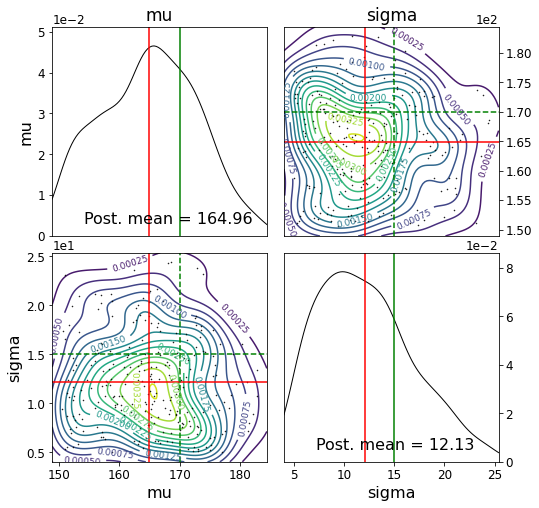

In [166]:
journal.plot_posterior_distr(true_parameter_values=[170,15])

Also, we can save the journal to disk and reload it later:


In [86]:
from abcpy.output import Journal
journal.save("experiments.jnl")
new_journal = Journal.fromFile('experiments.jnl')

# Experiments to improve the result

In [1]:
from abcpy.continuousmodels import Uniform, Normal as Gaussian
from abcpy.statistics import Identity, LinearTransformation
import numpy as np
from abcpy.distances import Euclidean
from abcpy.backends import BackendDummy as Backend
from abcpy.inferences import RejectionABC

# define priors
mu = Uniform([[150], [200]], name="mu")
sigma = Uniform([[5], [25]], name="sigma")
# define the model
height = Gaussian([mu, sigma], name='height')

statistics_calculator = Identity(degree=2, cross=False)
distance_calculator = Euclidean(statistics_calculator)
backend = Backend()

sampler = RejectionABC([height], [distance_calculator], backend, seed=1)

height_obs = height.forward_simulate([170, 15], k=50)

In [4]:
# Try 100 times

n_sample, n_samples_per_param = 250, 10
epsilon = 5000

for i in range(10):
    journal = sampler.sample([height_obs], n_sample, n_samples_per_param, epsilon)
    print("Posterior mean", journal.posterior_mean())
    print("Covariance matrix:")
    print(journal.posterior_cov())

Posterior mean {'mu': 174.082358109774, 'sigma': 9.896525105115025}
Covariance matrix:
(array([[41.10626216,  0.56391029],
       [ 0.56391029, 11.39813444]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 173.83917055465642, 'sigma': 9.687284610823793}
Covariance matrix:
(array([[50.45603079, -0.55852689],
       [-0.55852689, 14.51555156]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 174.15828005466713, 'sigma': 10.001145343308574}
Covariance matrix:
(array([[44.07811931,  1.77485313],
       [ 1.77485313, 13.69988849]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 175.0609435894026, 'sigma': 9.52964254591091}
Covariance matrix:
(array([[45.95145524, -0.76151904],
       [-0.76151904, 11.62176245]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 174.4322950114626, 'sigma': 9.801025571754039}
Covariance matrix:
(array([[42.41921684,  0.97114856],
       [ 0.97114856, 12.24645914]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 173.88641140653039, 'sigma': 10.

In [5]:
# define priors
mu = Uniform([[150], [200]], name="mu")
sigma = Uniform([[5], [25]], name="sigma")
# define the model
height = Gaussian([mu, sigma], name='height')

statistics_calculator = Identity(degree=2, cross=False)
distance_calculator = Euclidean(statistics_calculator)
backend = Backend()

sampler = RejectionABC([height], [distance_calculator], backend, seed=1)

height_obs = height.forward_simulate([170, 15], k=50)

In [6]:
for i in range(10):
    journal = sampler.sample([height_obs], n_sample, n_samples_per_param, epsilon)
    print("Posterior mean", journal.posterior_mean())
    print("Covariance matrix:")
    print(journal.posterior_cov())

Posterior mean {'mu': 170.6988724876613, 'sigma': 9.44350588271045}
Covariance matrix:
(array([[39.5407604 , -2.41831168],
       [-2.41831168, 12.79642855]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 169.5579235796013, 'sigma': 9.3911871125684}
Covariance matrix:
(array([[40.95262594, -0.69749393],
       [-0.69749393, 10.21814037]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 170.72741861141932, 'sigma': 9.38092926554344}
Covariance matrix:
(array([[39.50183866, -1.32462216],
       [-1.32462216, 12.00578552]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 169.89214768098708, 'sigma': 9.695339564603016}
Covariance matrix:
(array([[41.95361173, -1.08807148],
       [-1.08807148, 14.08547688]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 170.03590448306005, 'sigma': 9.756190671741049}
Covariance matrix:
(array([[40.26777121,  1.54237023],
       [ 1.54237023, 13.53644171]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 169.93372593548875, 'sigma': 9.503

Now we can change some hyper-parameters.

In [11]:
# define priors
mu = Uniform([[150], [200]], name="mu")
sigma = Uniform([[9], [20]], name="sigma")
# define the model
height = Gaussian([mu, sigma], name='height')

statistics_calculator = Identity(degree=2, cross=False)
distance_calculator = Euclidean(statistics_calculator)
backend = Backend()

sampler = RejectionABC([height], [distance_calculator], backend, seed=1)

height_obs = height.forward_simulate([170, 15], k=50)

In [8]:
for i in range(10):
    journal = sampler.sample([height_obs], n_sample, n_samples_per_param, epsilon)
    print("Posterior mean", journal.posterior_mean())
    print("Covariance matrix:")
    print(journal.posterior_cov())

Posterior mean {'mu': 172.79381997211672, 'sigma': 11.876557038190164}
Covariance matrix:
(array([[37.57572185, -1.28711643],
       [-1.28711643,  6.68289134]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 171.89233062714183, 'sigma': 12.039562236215417}
Covariance matrix:
(array([[33.9783512 ,  0.79250043],
       [ 0.79250043,  6.2438972 ]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 172.65862557296012, 'sigma': 11.799172744204593}
Covariance matrix:
(array([[32.91813058, -1.03175197],
       [-1.03175197,  5.37024955]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 171.79844679012695, 'sigma': 12.098152999625126}
Covariance matrix:
(array([[40.95004919,  0.1451407 ],
       [ 0.1451407 ,  7.17654101]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 171.89345146839105, 'sigma': 12.11374237529622}
Covariance matrix:
(array([[37.72134773,  1.18121986],
       [ 1.18121986,  6.16888544]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 171.99882609505923, 'sig

## Adjust $\epsilon$

In [1]:
from abcpy.continuousmodels import Uniform, Normal as Gaussian
from abcpy.statistics import Identity, LinearTransformation
import numpy as np
from abcpy.distances import Euclidean
from abcpy.backends import BackendDummy as Backend
from abcpy.inferences import RejectionABC

# define priors
mu = Uniform([[150], [200]], name="mu")
sigma = Uniform([[9], [20]], name="sigma")
# define the model
height = Gaussian([mu, sigma], name='height')

statistics_calculator = Identity(degree=2, cross=False)
distance_calculator = Euclidean(statistics_calculator)
backend = Backend()

sampler = RejectionABC([height], [distance_calculator], backend, seed=1)

height_obs = height.forward_simulate([170, 15], k=50)

In [3]:
# Try 100 times

n_sample, n_samples_per_param = 250, 10
epsilon = 5000

for i in range(10):
    journal = sampler.sample([height_obs], n_sample, n_samples_per_param, epsilon)
    print("Posterior mean", journal.posterior_mean())
    print("Covariance matrix:")
    print(journal.posterior_cov())

Posterior mean {'mu': 168.4240167715241, 'sigma': 12.508170830012038}
Covariance matrix:
(array([[46.64606622,  0.29324402],
       [ 0.29324402,  6.99693676]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 167.3236015613427, 'sigma': 12.514111112977224}
Covariance matrix:
(array([[44.74614526, -0.63807765],
       [-0.63807765,  6.46171534]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 167.12310142529327, 'sigma': 12.529823568286142}
Covariance matrix:
(array([[49.667755  , -1.73413511],
       [-1.73413511,  7.18426007]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 166.37081388915416, 'sigma': 12.903049812326088}
Covariance matrix:
(array([[44.77934554, -1.34030285],
       [-1.34030285,  8.33594468]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 166.68906871743573, 'sigma': 12.695831740386009}
Covariance matrix:
(array([[45.02798914, -0.22259543],
       [-0.22259543,  7.02127114]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 166.39428534782195, 'sigm

In [6]:
# Try 100 times

n_sample, n_samples_per_param = 250, 10
epsilon = 4500

for i in range(10):
    journal = sampler.sample([height_obs], n_sample, n_samples_per_param, epsilon)
    print("Posterior mean", journal.posterior_mean())
    print("Covariance matrix:")
    print(journal.posterior_cov())

Posterior mean {'mu': 167.98556685719998, 'sigma': 11.94007112875411}
Covariance matrix:
(array([[33.95214286,  0.17577722],
       [ 0.17577722,  5.42745645]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 166.66350313326313, 'sigma': 11.724252005126736}
Covariance matrix:
(array([[34.43248176, -0.70438866],
       [-0.70438866,  5.94490388]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 166.6265988692357, 'sigma': 11.960020593904751}
Covariance matrix:
(array([[30.21039642, -1.18917498],
       [-1.18917498,  5.55670608]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 167.9683883757208, 'sigma': 11.748881979500311}
Covariance matrix:
(array([[32.34622363, -1.0479005 ],
       [-1.0479005 ,  4.76290884]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 167.9542713960746, 'sigma': 11.712802683367157}
Covariance matrix:
(array([[35.90613425, -1.38737874],
       [-1.38737874,  5.75805822]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 167.43955262103404, 'sigma'

In [15]:
# Try 100 times

n_sample, n_samples_per_param = 250, 10
epsilon = 4000

for i in range(10):
    #journal = sampler.sample([height_obs], n_sample, n_samples_per_param, epsilon)
    print("Posterior mean", journal.posterior_mean())
    print("Covariance matrix:")
    print(journal.posterior_cov())

Posterior mean {'mu': 168.13573971162643, 'sigma': 8.218819872601806}
Covariance matrix:
(array([[32.31111766,  0.63739617],
       [ 0.63739617,  8.60027862]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 168.13573971162643, 'sigma': 8.218819872601806}
Covariance matrix:
(array([[32.31111766,  0.63739617],
       [ 0.63739617,  8.60027862]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 168.13573971162643, 'sigma': 8.218819872601806}
Covariance matrix:
(array([[32.31111766,  0.63739617],
       [ 0.63739617,  8.60027862]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 168.13573971162643, 'sigma': 8.218819872601806}
Covariance matrix:
(array([[32.31111766,  0.63739617],
       [ 0.63739617,  8.60027862]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 168.13573971162643, 'sigma': 8.218819872601806}
Covariance matrix:
(array([[32.31111766,  0.63739617],
       [ 0.63739617,  8.60027862]]), dict_keys(['mu', 'sigma']))
Posterior mean {'mu': 168.13573971162643, 'sigma':

## Change the true distribution

In [2]:
from abcpy.continuousmodels import Uniform, Normal as Gaussian
from abcpy.statistics import Identity, LinearTransformation
import numpy as np
from abcpy.distances import Euclidean
from abcpy.backends import BackendDummy as Backend
from abcpy.inferences import RejectionABC

# define priors
mu = Uniform([[150], [200]], name="mu")
sigma = Uniform([[5], [25]], name="sigma")
# define the model
height = Gaussian([mu, sigma], name='height')

statistics_calculator = Identity(degree=2, cross=False)
distance_calculator = Euclidean(statistics_calculator)
backend = Backend()

sampler = RejectionABC([height], [distance_calculator], backend, seed=1)

# Try 100 times

n_sample, n_samples_per_param = 250, 10
epsilon = 5000

for i in range(10):
    height_obs = height.forward_simulate([170, 15], k=50)
    journal = sampler.sample([height_obs], n_sample, n_samples_per_param, epsilon)
    print("Posterior mean", journal.posterior_mean())
    #print("Covariance matrix:")
    #print(journal.posterior_cov())
    print(2*np.sqrt(journal.posterior_cov()[0][1][1]))

Posterior mean {'mu': 168.1832380964319, 'sigma': 8.804792082646534}
6.174799898979999
Posterior mean {'mu': 173.7945390837748, 'sigma': 7.609908587006823}
4.270911077268013
Posterior mean {'mu': 163.9130216155541, 'sigma': 9.304590723683626}
6.848924183926451
Posterior mean {'mu': 167.12973968238694, 'sigma': 9.866570104750298}
7.586050830950593
Posterior mean {'mu': 169.3824573901014, 'sigma': 9.346508545449753}
6.8796079607247425
Posterior mean {'mu': 169.3373466331486, 'sigma': 10.064134171706053}
7.833512119453973
Posterior mean {'mu': 169.27037413582173, 'sigma': 8.719872358461558}
6.236733983878052
Posterior mean {'mu': 170.2998565293545, 'sigma': 9.115420287374997}
5.886092283381347
Posterior mean {'mu': 166.7736834849068, 'sigma': 10.267912964007795}
8.100861043720945
Posterior mean {'mu': 171.9995608780263, 'sigma': 10.576212499085544}
7.760599893236201


/var/folders/m7/0c6k6n3j4dl5gy8xc8rjf3jm0000gn/T/ipykernel_2229/2691086824.py:27: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  ax = fig.add_axes()


<Figure size 720x504 with 0 Axes>

Posterior mean {'mu': 169.54902969042578, 'sigma': 10.462575157175026}
8.281489660002432
Posterior mean {'mu': 169.8172094187407, 'sigma': 9.875803510113219}
6.931720670394547
Posterior mean {'mu': 169.6213791052105, 'sigma': 9.464263582218448}
6.960596662610296
Posterior mean {'mu': 169.6589298341518, 'sigma': 11.050969477285452}
8.301181295715216
Posterior mean {'mu': 169.9954788452244, 'sigma': 11.141221514128468}
8.14717754066075


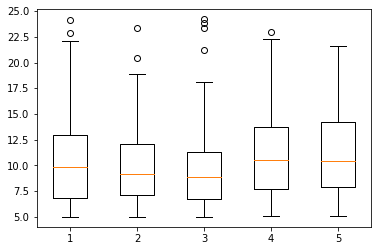

In [58]:
from abcpy.continuousmodels import Uniform, Normal as Gaussian
from abcpy.statistics import Identity, LinearTransformation
import numpy as np
from abcpy.distances import Euclidean
from abcpy.backends import BackendDummy as Backend
from abcpy.inferences import RejectionABC

# define priors
mu = Uniform([[150], [200]], name="mu")
sigma = Uniform([[5], [25]], name="sigma")
# define the model
height = Gaussian([mu, sigma], name='height')

statistics_calculator = Identity(degree=2, cross=False)
distance_calculator = Euclidean(statistics_calculator)
backend = Backend()

sampler = RejectionABC([height], [distance_calculator], backend, seed=1)

# Try 100 times

n_sample, n_samples_per_param = 250, 15
epsilon = 5000

fig = plt.figure(figsize =(10, 7))
 # Creating axes instance
ax = fig.add_axes()

data = [0, 0, 0, 0, 0]
 

for i in range(5):
    height_obs = height.forward_simulate([170, 10], k=50)
    journal = sampler.sample([height_obs], n_sample, n_samples_per_param, epsilon)
    print("Posterior mean", journal.posterior_mean())
    #print("Covariance matrix:")
    #print(journal.posterior_cov())
    print(2*np.sqrt(journal.posterior_cov()[0][1][1]))
    
 
    # Creating plot
    params = journal.get_parameters()
    data[i] = np.array(np.squeeze(params['sigma']))
    #bp = plt.boxplot(np.squeeze(params['sigma']))
bp = plt.boxplot(data)

plt.show()

In [2]:
from abcpy.continuousmodels import Uniform, Normal as Gaussian
from abcpy.statistics import Identity, LinearTransformation
import numpy as np
from abcpy.distances import Euclidean
from abcpy.backends import BackendDummy as Backend
from abcpy.inferences import RejectionABC

# define priors
mu = Uniform([[150], [200]], name="mu")
sigma = Uniform([[5], [25]], name="sigma")
# define the model
height = Gaussian([mu, sigma], name='height')

statistics_calculator = Identity(degree=2, cross=False)
distance_calculator = Euclidean(statistics_calculator)
backend = Backend()

sampler = RejectionABC([height], [distance_calculator], backend, seed=1)

# Try 100 times

n_sample, n_samples_per_param = 250, 15
epsilon = 5000

for i in range(10):
    height_obs = height.forward_simulate([170, 7], k=50)
    journal = sampler.sample([height_obs], n_sample, n_samples_per_param, epsilon)
    print("Posterior mean", journal.posterior_mean())
    #print("Covariance matrix:")
    #print(journal.posterior_cov())
    print(2*np.sqrt(journal.posterior_cov()[0][1][1]))

Posterior mean {'mu': 167.95701595521854, 'sigma': 11.25183537176152}
9.04004308884493
Posterior mean {'mu': 170.00749492597686, 'sigma': 10.909974077642312}
8.160492125523746
Posterior mean {'mu': 169.6491193827086, 'sigma': 11.02871163995692}
8.882626531593418
Posterior mean {'mu': 169.067294244475, 'sigma': 11.31050098671363}
8.354617904553269
Posterior mean {'mu': 168.67478461379494, 'sigma': 11.471782443885498}
8.295649667553517
Posterior mean {'mu': 168.38272496577997, 'sigma': 11.686132834265466}
9.488691730655718
Posterior mean {'mu': 168.60890470026393, 'sigma': 11.213642893608565}
8.624878760945391
Posterior mean {'mu': 167.84369072213622, 'sigma': 10.698005112287905}
7.692573450708069
Posterior mean {'mu': 169.0539942296882, 'sigma': 11.71430435849379}
9.129191520992737
Posterior mean {'mu': 167.5202665947388, 'sigma': 11.503531310064067}
8.401362085599446


In [3]:
from abcpy.continuousmodels import Uniform, Normal as Gaussian
from abcpy.statistics import Identity, LinearTransformation
import numpy as np
from abcpy.distances import Euclidean
from abcpy.backends import BackendDummy as Backend
from abcpy.inferences import RejectionABC

# define priors
mu = Uniform([[150], [200]], name="mu")
sigma = Uniform([[5], [25]], name="sigma")
# define the model
height = Gaussian([mu, sigma], name='height')

statistics_calculator = Identity(degree=2, cross=False)
distance_calculator = Euclidean(statistics_calculator)
backend = Backend()

sampler = RejectionABC([height], [distance_calculator], backend, seed=1)

# Try 100 times

n_sample, n_samples_per_param = 250, 15
epsilon = 5000

for i in range(10):
    height_obs = height.forward_simulate([170, 5], k=50)
    journal = sampler.sample([height_obs], n_sample, n_samples_per_param, epsilon)
    print("Posterior mean", journal.posterior_mean())
    #print("Covariance matrix:")
    #print(journal.posterior_cov())
    print(2*np.sqrt(journal.posterior_cov()[0][1][1]))

Posterior mean {'mu': 169.88481232964097, 'sigma': 11.404278388203126}
9.255460847792653
Posterior mean {'mu': 169.35133118077408, 'sigma': 11.316865210168077}
8.782367369652526
Posterior mean {'mu': 170.22552212372716, 'sigma': 11.417106633595719}
9.048561086894653
Posterior mean {'mu': 168.44429428691146, 'sigma': 11.334963827959356}
8.485089877478522
Posterior mean {'mu': 168.42568927984055, 'sigma': 11.5399744898274}
8.390167130658797
Posterior mean {'mu': 167.98338204918213, 'sigma': 12.155354130661614}
9.841561278401608
Posterior mean {'mu': 170.4815934293206, 'sigma': 11.611288513763213}
9.189545275478388
Posterior mean {'mu': 168.82398181254598, 'sigma': 11.070963989938269}
8.034742300429087
Posterior mean {'mu': 169.95931318990839, 'sigma': 11.694082885199363}
9.031420552039416
Posterior mean {'mu': 167.19343263545903, 'sigma': 12.004038690991152}
8.634172794962428


In [25]:
from abcpy.continuousmodels import Uniform, Normal as Gaussian
from abcpy.statistics import Identity, LinearTransformation
import numpy as np
from abcpy.distances import Euclidean
from abcpy.backends import BackendDummy as Backend
from abcpy.inferences import RejectionABC

# define priors
mu = Uniform([[150], [200]], name="mu")
sigma = Uniform([[5], [25]], name="sigma")
# define the model
height = Gaussian([mu, sigma], name='height')

statistics_calculator = Identity(degree=2, cross=False)
distance_calculator = Euclidean(statistics_calculator)
backend = Backend()

sampler = RejectionABC([height], [distance_calculator], backend, seed=1)

# Try 100 times

n_sample, n_samples_per_param = 250, 15
epsilon = 5000

for i in range(5):
    height_obs = height.forward_simulate([170, 5], k=50)
    journal = sampler.sample([height_obs], n_sample, n_samples_per_param, epsilon)
    print("Posterior mean", journal.posterior_mean())
    #print("Covariance matrix:")
    #print(journal.posterior_cov())
    print(2*np.sqrt(journal.posterior_cov()[0][1][1]))

Posterior mean {'mu': 169.074029532174, 'sigma': 11.373417640577202}
9.187729401964745
Posterior mean {'mu': 169.15924259316188, 'sigma': 11.188174146330594}
8.727031558313959
Posterior mean {'mu': 169.49697424657597, 'sigma': 11.621272105611668}
9.205332730824448
Posterior mean {'mu': 168.29164503292884, 'sigma': 11.358925731545988}
8.475107439259318
Posterior mean {'mu': 169.8074111806503, 'sigma': 11.5962329570437}
8.500627635292302


# Measure the distance

In [28]:
from abcpy.continuousmodels import Uniform, Normal as Gaussian
from abcpy.statistics import Identity, LinearTransformation
import numpy as np
from abcpy.distances import Euclidean
from abcpy.backends import BackendDummy as Backend
from abcpy.inferences import RejectionABC

# define priors
mu = Uniform([[150], [200]], name="mu")
sigma = Uniform([[5], [25]], name="sigma")
# define the model
height = Gaussian([mu, sigma], name='height')

statistics_calculator = Identity(degree=2, cross=False)
distance_calculator = Euclidean(statistics_calculator)
backend = Backend()

sampler = RejectionABC([height], [distance_calculator], backend, seed=1)

# Try 100 times

n_sample, n_samples_per_param = 250, 15
epsilon = 5000

height_obs0 = height.forward_simulate([170, 10], k=50)
journal0 = sampler.sample([height_obs0], n_sample, n_samples_per_param, epsilon)
print("Posterior mean", journal0.posterior_mean())
print("Covariance matrix:")
print(journal0.posterior_cov())
#print(2*np.sqrt(journal.posterior_cov()[0][1][1]))
distance_data = []
distance_mean_mu = []
distance_mean_sigma = []
distance_summary = []



for i in range(10):
    height_obs = height.forward_simulate([170, 10], k=50)
    distance_data.append(np.linalg.norm(np.array(height_obs) - np.array(height_obs0)))
    distance_summary.append(distance_calculator.distance(height_obs, height_obs0))
    journal = sampler.sample([height_obs], n_sample, n_samples_per_param, epsilon)
    #print("Posterior mean", journal.posterior_mean())
    #print("Covariance matrix:")
    #print(journal.posterior_cov())
    #print(2*np.sqrt(journal.posterior_cov()[0][1][1]))
    distance_mean_mu.append(np.linalg.norm(journal.posterior_mean()['mu'] - journal0.posterior_mean()['mu']))
    distance_mean_sigma.append(np.linalg.norm(journal.posterior_mean()['sigma'] - journal0.posterior_mean()['sigma']))
    

Posterior mean {'mu': 170.3706016192351, 'sigma': 10.451779385717444}
Covariance matrix:
(array([[52.54811852, -2.10673592],
       [-2.10673592, 16.88338478]]), dict_keys(['mu', 'sigma']))


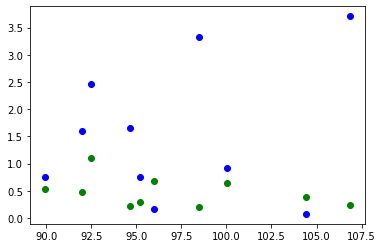

In [29]:
import matplotlib.pyplot as plt

fig0 = plt.figure()
plt.plot(distance_data, distance_mean_mu, 'bo')
plt.plot(distance_data, distance_mean_sigma, 'go')
plt.show()

In [5]:
from abcpy.continuousmodels import Uniform, Normal as Gaussian
from abcpy.statistics import Identity, LinearTransformation
import numpy as np
from abcpy.distances import Euclidean
from abcpy.backends import BackendDummy as Backend
from abcpy.inferences import RejectionABC

# define priors
mu = Uniform([[150], [200]], name="mu")
sigma = Uniform([[5], [25]], name="sigma")
# define the model
height = Gaussian([mu, sigma], name='height')

statistics_calculator = Identity(degree=2, cross=False)
distance_calculator = Euclidean(statistics_calculator)
backend = Backend()

sampler = RejectionABC([height], [distance_calculator], backend, seed=1)

# Try 100 times

n_sample, n_samples_per_param = 250, 15
epsilon = 5000

height_obs0 = height.forward_simulate([170, 10], k=50)
journal0 = sampler.sample([height_obs0], n_sample, n_samples_per_param, epsilon)
print("Posterior mean", journal0.posterior_mean())
print("Covariance matrix:")
print(journal0.posterior_cov())
#print(2*np.sqrt(journal.posterior_cov()[0][1][1]))
distance_data = []
distance_mean_mu = []
distance_mean_sigma = []



for i in range(100):
    height_obs = height.forward_simulate([170, 10], k=50)
    distance_data.append(np.linalg.norm(np.array(height_obs) - np.array(height_obs0)))
    journal = sampler.sample([height_obs], n_sample, n_samples_per_param, epsilon)
    #print("Posterior mean", journal.posterior_mean())
    #print("Covariance matrix:")
    #print(journal.posterior_cov())
    #print(2*np.sqrt(journal.posterior_cov()[0][1][1]))
    distance_mean_mu.append(np.linalg.norm(journal.posterior_mean()['mu'] - journal0.posterior_mean()['mu']))
    distance_mean_sigma.append(np.linalg.norm(journal.posterior_mean()['sigma'] - journal0.posterior_mean()['sigma']))
    

Posterior mean {'mu': 170.40870773971906, 'sigma': 10.540685357784366}
Covariance matrix:
(array([[55.02066989, -2.03803821],
       [-2.03803821, 17.31793419]]), dict_keys(['mu', 'sigma']))


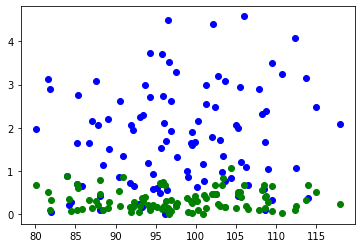

In [6]:
import matplotlib.pyplot as plt

fig0 = plt.figure()
plt.plot(distance_data, distance_mean_mu, 'bo')
plt.plot(distance_data, distance_mean_sigma, 'go')
plt.show()

## Measure the Hell distance

In [108]:
def hell(y0, y1, step = 0.2, plot = False):
    ''' Compute Hellinger distance for two accepted parameter sets.
    :params y0, y1: data
            step: width of bins for the histgram
    '''
    # Interval for the histogram
    a = min(np.amin(y0), np.amin(y1))
    b = max(np.amax(y0), np.amax(y1))
    
    # generate histgrams for the two data sets
    hist0 = np.histogram(y0, bins = np.arange(a, b, step), density = True)
    hist1 = np.histogram(y1, bins = np.arange(a, b, step), density = True)
    
    return hellinger(hist0[0]/100, hist1[0]/100)

def hellinger(p, q):
    """Hellinger distance between distributions"""
    return np.sqrt(sum([(np.sqrt(t[0])-np.sqrt(t[1]))**2
                for t in zip(p,q)])) / np.sqrt(2.)

In [109]:
from abcpy.continuousmodels import Uniform, Normal as Gaussian
from abcpy.statistics import Identity, LinearTransformation
import numpy as np
from abcpy.distances import Euclidean
from abcpy.backends import BackendDummy as Backend
from abcpy.inferences import RejectionABC

# define priors
mu = Uniform([[150], [200]], name="mu")
sigma = Uniform([[5], [25]], name="sigma")
# define the model
height = Gaussian([mu, sigma], name='height')

statistics_calculator = Identity(degree=2, cross=False)
distance_calculator = Euclidean(statistics_calculator)
backend = Backend()

sampler = RejectionABC([height], [distance_calculator], backend, seed=1)

# Try 100 times

n_sample, n_samples_per_param = 250, 15
epsilon = 5000

height_obs0 = height.forward_simulate([170, 10], k=50)
journal0 = sampler.sample([height_obs0], n_sample, n_samples_per_param, epsilon)
params0= journal0.get_parameters()
print("Posterior mean", journal0.posterior_mean())
print("Covariance matrix:")
print(journal0.posterior_cov())
#print(2*np.sqrt(journal.posterior_cov()[0][1][1]))
distance_data = []
distance_mean_mu = []
distance_mean_sigma = []
distance_summary = []
hell_mu = []
hell_sigma = []
distance_summary = []
hell_data = []
hell_summary = []



for i in range(50):
    height_obs = height.forward_simulate([170, 10], k=50)
    distance_data.append(np.linalg.norm(np.array(height_obs) - np.array(height_obs0)))
    distance_summary.append(distance_calculator.distance(height_obs, height_obs0))
    hell_data.append(hell(height_obs, height_obs0))
    
    journal = sampler.sample([height_obs], n_sample, n_samples_per_param, epsilon)
    #print("Posterior mean", journal.posterior_mean())
    #print("Covariance matrix:")
    #print(journal.posterior_cov())
    #print(2*np.sqrt(journal.posterior_cov()[0][1][1]))
    
    distance_mean_mu.append(np.linalg.norm(journal.posterior_mean()['mu'] - journal0.posterior_mean()['mu']))
    distance_mean_sigma.append(np.linalg.norm(journal.posterior_mean()['sigma'] - journal0.posterior_mean()['sigma']))
    params = journal.get_parameters()
    
    hell_mu.append(hell(params0['mu'], params['mu']))
    hell_sigma.append(hell(params0['sigma'], params['sigma']))
    
    

Posterior mean {'mu': 170.9671580476354, 'sigma': 10.439398077508603}
Covariance matrix:
(array([[52.45713565, -2.57851379],
       [-2.57851379, 16.68543982]]), dict_keys(['mu', 'sigma']))


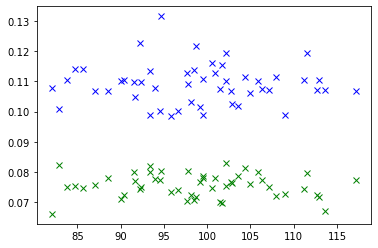

In [110]:
import matplotlib.pyplot as plt

fig0 = plt.figure()
#plt.plot(distance_data, distance_mean_mu, 'bo')
#plt.plot(distance_data, distance_mean_sigma, 'go')

plt.plot(distance_data, hell_mu, 'bx')
plt.plot(distance_data, hell_sigma, 'gx')
#print(hell_mu)
#print(hell_sigma)

plt.show()

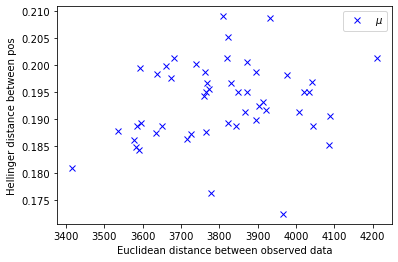

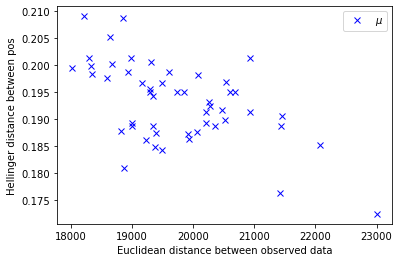

In [111]:
fig0 = plt.figure()
#plt.plot(distance_data, distance_mean_mu, 'bo')
#plt.plot(distance_data, distance_mean_sigma, 'go')

plt.plot(distance_summary, hell_data, 'bx', label=r'$\mu$')
#plt.plot(distance_summary, hell_sigma, 'gx', label=r'$\sigma$')
#print(hell_mu)
#print(hell_sigma)
plt.xlabel('Euclidean distance between observed data')
plt.ylabel('Hellinger distance between pos')
#plt.title('Histogram of IQ')

plt.legend()
plt.savefig('hell2')

plt.show()

fig0 = plt.figure()
#plt.plot(distance_data, distance_mean_mu, 'bo')
#plt.plot(distance_data, distance_mean_sigma, 'go')

plt.plot(np.array(distance_summary)/np.array(hell_data)
         , hell_data, 'bx', label=r'$\mu$')
#plt.plot(distance_summary, hell_sigma, 'gx', label=r'$\sigma$')
#print(hell_mu)
#print(hell_sigma)
plt.xlabel('Euclidean distance between observed data')
plt.ylabel('Hellinger distance between pos')
#plt.title('Histogram of IQ')

plt.legend()
plt.savefig('hell2')

plt.show()



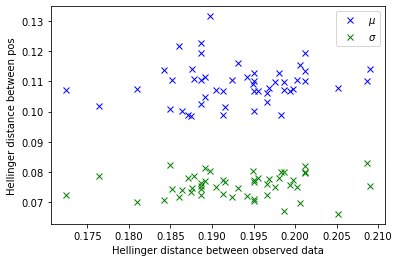

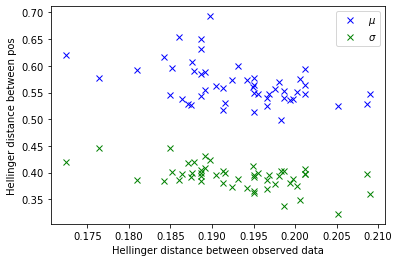

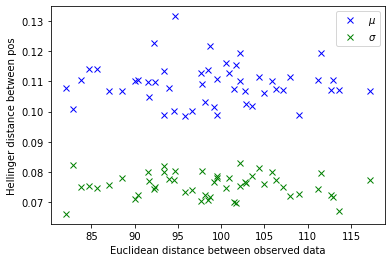

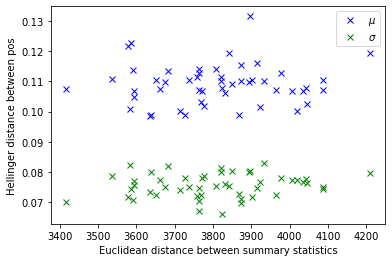

In [112]:
import matplotlib.pyplot as plt

fig0 = plt.figure()
#plt.plot(distance_data, distance_mean_mu, 'bo')
#plt.plot(distance_data, distance_mean_sigma, 'go')

plt.plot(hell_data, hell_mu, 'bx', label=r'$\mu$')
plt.plot(hell_data, hell_sigma, 'gx', label=r'$\sigma$')
#print(hell_mu)
#print(hell_sigma)
plt.xlabel('Hellinger distance between observed data')
plt.ylabel('Hellinger distance between pos')
#plt.title('Histogram of IQ')

plt.legend()
plt.savefig('hell2')

plt.show()

fig0 = plt.figure()
#plt.plot(distance_data, distance_mean_mu, 'bo')
#plt.plot(distance_data, distance_mean_sigma, 'go')

plt.plot(hell_data, np.array(hell_mu)/np.array(hell_data), 'bx', label=r'$\mu$')
plt.plot(hell_data, np.array(hell_sigma)/np.array(hell_data), 'gx', label=r'$\sigma$')
#print(hell_mu)
#print(hell_sigma)
plt.xlabel('Hellinger distance between observed data')
plt.ylabel('Hellinger distance between pos')
#plt.title('Histogram of IQ')

plt.legend()
plt.savefig('hell2')

plt.show()

fig0 = plt.figure()
#plt.plot(distance_data, distance_mean_mu, 'bo')
#plt.plot(distance_data, distance_mean_sigma, 'go')

plt.plot(distance_data, hell_mu, 'bx', label=r'$\mu$')
plt.plot(distance_data, hell_sigma, 'gx', label=r'$\sigma$')
#print(hell_mu)
#print(hell_sigma)
plt.xlabel('Euclidean distance between observed data')
plt.ylabel('Hellinger distance between pos')
#plt.title('Histogram of IQ')

plt.legend()
plt.savefig('hell2')

plt.show()

fig0 = plt.figure()
#plt.plot(distance_data, distance_mean_mu, 'bo')
#plt.plot(distance_data, distance_mean_sigma, 'go')

plt.plot(distance_summary, hell_mu, 'bx', label=r'$\mu$')
plt.plot(distance_summary, hell_sigma, 'gx', label=r'$\sigma$')
#print(hell_mu)
#print(hell_sigma)
plt.xlabel('Euclidean distance between summary statistics')
plt.ylabel('Hellinger distance between pos')
#plt.title('Histogram of IQ')

plt.legend()
plt.savefig('hell2')

plt.show()



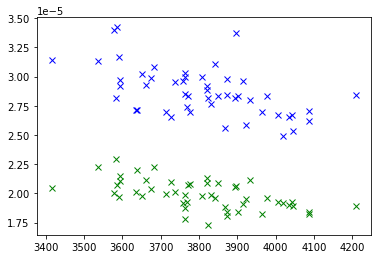

In [113]:
hell_mu_normed = np.array(hell_mu)/np.array(distance_summary)
hell_sigma_normed = np.array(hell_sigma)/np.array(distance_summary)

plt.plot(distance_summary, hell_mu_normed, 'bx')
plt.plot(distance_summary, hell_sigma_normed, 'gx')


## Verify convergence

## Compute continuous Hell distance

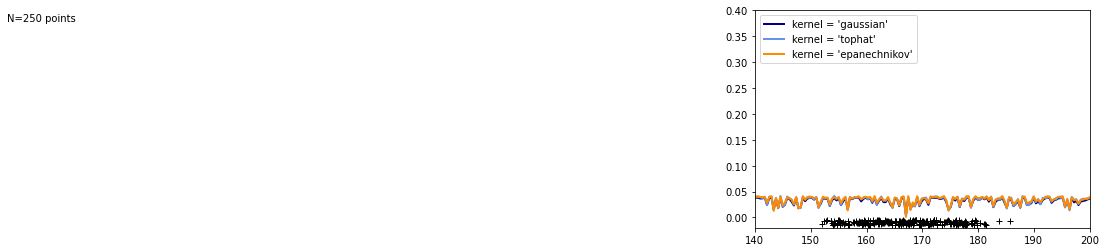

In [143]:
# Compute estimated density
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.utils.fixes import parse_version

# ----------------------------------------------------------------------
# Plot a 1D density example


#X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
X = np.reshape(np.array([np.squeeze(params['mu'])]), (250, 1))
N = 250
X_plot = np.linspace(100, 200, N)[:, np.newaxis]

#true_dens = 0.3 * norm(0, 1).pdf(X_plot[:, 0]) + 0.7 * norm(5, 1).pdf(X_plot[:, 0])


fig, ax = plt.subplots()
#ax.fill(X_plot[:, 0], true_dens, fc="black", alpha=0.2, label="input distribution")
colors = ["navy", "cornflowerblue", "darkorange"]
kernels = ["gaussian", "tophat", "epanechnikov"]
lw = 2

for color, kernel in zip(colors, kernels):
    #print(X)
    kde = KernelDensity(kernel=kernel, bandwidth=5).fit(X)
    log_dens = kde.score_samples(X)
    #print(log_dens)
    ax.plot(
        X_plot[:, 0],
        np.exp(log_dens),
        color=color,
        lw=lw,
        linestyle="-",
        label="kernel = '{0}'".format(kernel),
    )

ax.text(6, 0.38, "N={0} points".format(N))

ax.legend(loc="upper left")
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), "+k")

ax.set_xlim(140, 200)
ax.set_ylim(-0.02, 0.4)
plt.show()

0.04812755493304986


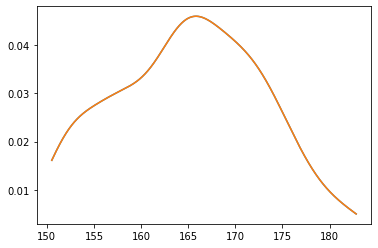

In [265]:
from scipy.stats import gaussian_kde


def Gaussian_kde(X, bandwidth, eval_points, plot = False):
    
    #positions = np.linspace(xmin, xmax, 100)
    kernel = gaussian_kde(X, bw_method=bandwidth)
    y_sp = kernel.pdf(eval_points)
    
    if plot:
        plt.plot(eval_points, y_sp)
    
    return y_sp

def hell_Gaussian(y0, y1, bandwidth, n, plot = False, squeeze = True):
    ''' Compute Hellinger distance for two accepted parameter sets.
    :params y0, y1: data
            step: width of bins for the histgram
    '''
    if squeeze:
        y0 = np.array(np.squeeze(y0))
        y1 = np.array(np.squeeze(y1))
        
    # Interval for the histogram
    a = min(np.amin(y0), np.amin(y1))
    b = max(np.amax(y0), np.amax(y1))
    
    eval_points = np.linspace(a, b, n)
    
    # Evaluate pdf of Gaussian kde
    p0 = Gaussian_kde(y0, bandwidth, eval_points, plot)
    p1 = Gaussian_kde(y1, bandwidth, eval_points, plot)
    
 
    # Evaluate continuous hell distance
    step = (b-a)/(n-1)
    d = continuous_hellinger(p0, p1, step)
    return d

def continuous_hellinger(f,g, step):
    """
    Given equally spaced values of pdf f,g, calculate Hellinger distance using Trapezoidal rule.
    """
    
    sq_fg = np.sqrt(f*g)
    
    return 1 - step*sum(sq_fg[1:-1])-step*(1/2)*(sq_fg[0]+sq_fg[-1])

def hellinger(p, q):
    """Hellinger distance between distributions"""
    return np.sqrt(sum([(np.sqrt(t[0])-np.sqrt(t[1]))**2
                for t in zip(p,q)])) / np.sqrt(2.)

X = np.array(np.squeeze(params['mu']))
Y = np.array(np.squeeze(params['sigma']))

y_sp = hell_Gaussian(params['mu'], params['mu'], 0.35, n=1000, plot = True)
print(y_sp)

#Z = np.reshape(kernel(positions).T, X.shape)
#print(kernel(3))